# Predict a Sine Wave with TensorFlow (Keras)

This notebook trains an LSTM model to predict a sine wave. It covers:

- Data generation (optionally with noise)
- Windowed time-series dataset creation
- tf.data pipeline
- LSTM model training with early stopping
- One-step and recursive multi-step forecasting

> ✅ Works with **TensorFlow 2.x** (uses `tf.keras`).


In [23]:
print ("hello world")

hello world


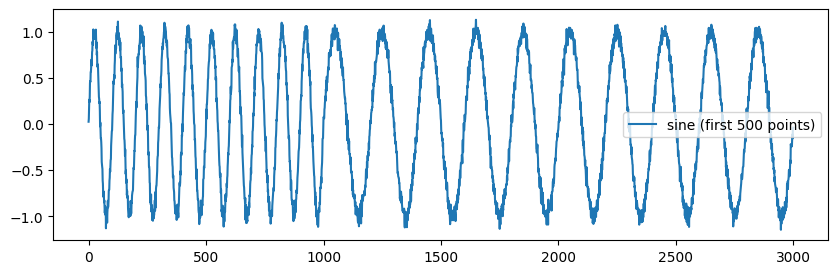

In [26]:
# 1) Setup and data generation
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate a sine wave (optionally with noise)
def make_sine(n_start=0,n_end=2000,pitch = 1, freq=0.01, amplitude=1.0, noise_std=0.0):
    x = np.arange(n_start,n_end)
    n_points = (n_end-n_start)/pitch
    y = amplitude * np.sin(2 * np.pi * freq * x)
    if noise_std > 0.0:
        y += np.random.normal(0, noise_std, size=int(n_points))

    new_x = np.reshape(x,(int(n_points),1))
    new_y = np.reshape(y,(int(n_points),1))

    return (new_x,new_y.astype(np.float32))

series = make_sine(n_start= 0,n_end=1000, freq=0.01, amplitude=1.0, noise_std=0.05)
series2 = make_sine(n_start= 1000,n_end=3000, freq=0.005, amplitude=1.0, noise_std=0.05)

new_series_x = np.vstack((series[0],series2[0]))
new_series_y = np.vstack((series[1],series2[1]))
new_series= (new_series_x,new_series_y)

plt.figure(figsize=(10, 3))
plt.plot(new_series[0],new_series[1], label='sine (first 500 points)')
plt.legend()
plt.show()


In [ ]:
# 2) Build a windowed dataset
WINDOW_SIZE = 64       # number of past steps as input
HORIZON = 1            # predict 1 step ahead

def make_windows(series, window_size=WINDOW_SIZE, horizon=HORIZON):
    X = []
    y = []
    for i in range(len(series) - window_size - horizon + 1):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size:i+window_size+horizon])
    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = make_windows(series[1], WINDOW_SIZE, HORIZON)
print("X shape:", X.shape, "y shape:", y.shape)

# Train/val/test split
train_size = int(0.7 * len(X))
val_size   = int(0.15 * len(X))
test_size  = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val,   y_val   = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test,  y_test  = X[train_size+val_size:], y[train_size+val_size:]

# Add channel dimension for RNNs/CNNs: (batch, time, features)
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

print("X_train:", X_train.shape, "y_train:", y_train.shape)


In [ ]:
# 3) Create a tf.data pipeline (efficient input)
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

def make_dataset(X, y, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    ds = ds.batch(batch_size).prefetch(AUTO)
    return ds

train_ds = make_dataset(X_train, y_train)
val_ds   = make_dataset(X_val, y_val, shuffle=False)
test_ds  = make_dataset(X_test, y_test, shuffle=False)


In [ ]:
# 4) Build the model (LSTM)
from tensorflow.keras import layers, models

def build_model(window_size=WINDOW_SIZE, horizon=HORIZON):
    model = models.Sequential([
        layers.Input(shape=(window_size, 1)),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(64, activation='relu'),
        layers.Dense(horizon)  # output 1 value (next step)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='mse',
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

model = build_model()
model.summary()


In [ ]:
# 5) Train the model
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training history')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()


In [ ]:
# 6) Evaluate and one-step forecast
test_loss, test_mae = model.evaluate(test_ds)
print(f"Test MSE: {test_loss:.6f}, Test MAE: {test_mae:.6f}")

# One-step predictions on the test set (aligned with windows)
y_pred_test = model.predict(test_ds)

# Plot a slice (first 200 points) of true vs predicted
plt.figure(figsize=(12,4))
plt.plot(y_test[:200, 0], label='True')
plt.plot(y_pred_test[:200, 0], label='Pred')
plt.title('One-step ahead predictions (test split)')
plt.legend()
plt.show()


In [ ]:
# 7) Recursive multi-step forecasting (optional)
def recursive_forecast(model, last_window, steps=200):
    """
    last_window: shape (WINDOW_SIZE,) or (WINDOW_SIZE, 1)
    returns: np.array of length `steps`
    """
    buf = last_window.astype(np.float32)
    if buf.ndim == 1:
        buf = buf[..., np.newaxis]  # (window, 1)

    preds = []
    for _ in range(steps):
        inp = buf[np.newaxis, ...]  # (1, window, 1)
        next_val = model.predict(inp, verbose=0)[0, 0]
        preds.append(next_val)
        buf = np.vstack([buf[1:], [[next_val]]])  # slide window
    return np.array(preds, dtype=np.float32)

# Take the last window from the series
last_window = series[-WINDOW_SIZE:]

future_steps = 300
future_preds = recursive_forecast(model, last_window, steps=future_steps)

# Plot continuation of the series
plt.figure(figsize=(12,4))
plt.plot(series[-500:], label='Recent true')
plt.plot(np.arange(len(series), len(series)+future_steps), future_preds, label='Future preds')
plt.title('Recursive multi-step forecast')
plt.legend()
plt.show()


## Tips & Variations

- **Remove noise** for a perfect sine: set `noise_std=0.0` in `make_sine`. With noise, the model generalizes better.
- **Window size**: For a given frequency, make sure your window covers at least one full cycle for best learning (e.g., if period ≈ 100, use `WINDOW_SIZE >= 100`).
- **Model alternatives**: Replace LSTM with `layers.GRU(64)` or a small 1D CNN.
- **Multi-output horizon**: Predict `HORIZON > 1` future steps directly by setting `HORIZON` and keeping `Dense(HORIZON)`.
- **Normalization**: For real data, normalize (e.g., z-score) before training.
- **Performance**: Tune depth/units, batch size, learning rate, or try sequence-to-sequence architectures for longer horizons.
